#  Web-scraping-bot project - data exploration

- Short exploration of a dataset about lifestyle and things to do in Tokyo from a specific website.
- The website's blog articles and related data have been directly scrapped from the web site.
- No data which could lead to this specific website will be shown in this notebook.

In [70]:
# import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scrappackage.scrap_blog_articles import Website_blog

In [71]:
# magic commands

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# The whole dataset have been scrapped before the creation of this notebook, a week ago.
# Since, some articles could have been published.
# Update the csv file which contains the dataset:
# To avoid scrap all the website's blog articles, update
# the all_articles.csv file with the website's blog articles from the
# first page only. This update could be done every two week as there were
# no more than 25 article publications per month in the past.

# instantiate the Website_blog class.
wb = Website_blog()

# update the csv file:
wb.update_csv_file_with_blog_first_page()

Scrap articles from the website's page 1
****************** 18 articles scrapped on this page.

'all_articles.csv' is now up to date.


In [99]:
# all_articles.csv relative path
all_articles_csv_file_path = os.path.join("..", "scrappackage", "all_articles.csv")
# read all_articles.csv in a panas dataframe                                                             
df = pd.read_csv(all_articles_csv_file_path)

In [74]:
df.columns

Index(['url', 'title', 'date', 'author', 'categories', 'tags', 'text'], dtype='object')

In [75]:
df.shape

(1609, 7)

In [81]:
df.count()

url           1609
title         1609
date          1520
author        1520
categories    1609
tags          1486
text          1609
dtype: int64

In [66]:
df.nunique()

url           1606
title         1605
date          1270
author         104
categories     176
tags          1385
text          1597
dtype: int64

In [85]:
c_url, c_title, c_date, c_author, c_categories, c_tags, c_text = df.count()
n_url, n_title, n_date, n_author, n_categories, n_tags, n_text = df.nunique()

In [93]:
print(f" - There are {c_url} articles in total")
print(f" - {c_title - n_title} duplicated titles")
print(f" - {c_url - c_date} articles have no publication date")
print(f" - More than one articles have been published on {c_date - n_date} publication dates")
print(f" - There are {n_author} authors")
print(f" - {'all' if c_url == c_categories else c_categories} articles have categories")
print(f" - {c_url - c_tags} articles don't have any tag")
print(f" - {c_text - n_text} duplicated texts")

 - There are 1609 articles in total
 - 4 duplicated titles
 - 89 articles have no publication date
 - More than one articles have been published on 250 publication dates
 - There are 104 authors
 - all articles have categories
 - 123 articles don't have any tag
 - 12 duplicated texts


In [183]:
# authors anonymation
# add a 'author_anon' column where each unique author name is replaced by a number (-1 if no author)
df['author_anon'] = df['author'].astype('category').cat.codes

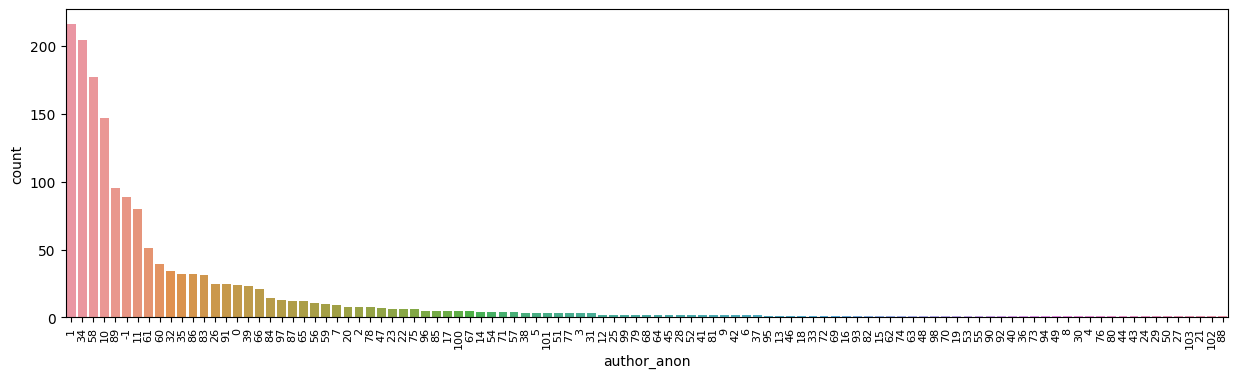

In [247]:
plt.figure(figsize=(15, 4))
sns.countplot(data=df, x='author_anon', order=df['author_anon'].value_counts().index)
plt.xticks(rotation=90, fontsize=8);

In [257]:
# nb articles wrote per author, using bins
df2 = df['author_anon'].value_counts().reset_index().rename(columns={'index': 'author', 'author_anon': 'nb_articles'})
bins = [1, 10, 30, 50, 100, 150, 200, 250]
groups = df2.groupby(['author', pd.cut(df2['nb_articles'], bins)])
articles_per_author_df = groups.size().unstack().agg(sum).reset_index()
articles_per_author_df.columns = ['nb_articles', 'nb_author']
articles_per_author_df

,nb_articles,nb_author
0,"(1, 10]",40
1,"(10, 30]",10
2,"(30, 50]",5
3,"(50, 100]",4
4,"(100, 150]",1
5,"(150, 200]",1
6,"(200, 250]",2


- A minority of authors wrote the majority of the articles

In [268]:
df2['perc'] = round((df2['nb_articles']/df2['nb_articles'].sum())*100, 2)
df2

,author,nb_articles,perc
0,1,216,13.42
1,34,204,12.68
2,58,177,11.00
3,10,147,9.14
4,89,95,5.90
...,...,...,...
100,27,1,0.06
101,103,1,0.06
102,21,1,0.06
103,102,1,0.06


In [274]:
# nb of articles written by top 5 authors
df2.nlargest(5, "perc", keep='first')[['nb_articles', 'perc']].sum()

nb_articles    839.00
perc            52.14
dtype: float64

The top five authors wrote 839 over 1609 articles, which represent more than 52% of the total of the articles.

In [275]:
# to be continued